In [42]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

## Sparse index fund

In [43]:
# number of stocks
n = 500
# number of factors (not described or needed in problem statement)
k = 20

# generate rbar, Sigma
# factor matrix, entries uniform on [-0.5,1]
F = 1.5 * np.random.rand(n, k) - 0.5
Sigma = 0.5 * F @ np.diag(np.random.rand(k)) @ F.T + np.diag(0.1 * np.random.rand(n))
# risk-free return (weekly, 5% annual)
mu_rf = 0.2
# Sharpe ratio
SR = 0.4
# expected return
rbar = mu_rf + SR * np.sqrt(np.diag(Sigma))
# market capitalization (index weights)
c = 5 + np.exp(2 * np.random.randn(n))

In [44]:
num_samples = 10000
r = np.random.multivariate_normal(rbar, Sigma, num_samples)
print(r.shape)

(10000, 500)


In [53]:
rhs = r @ c
threshold = 5e-1

In [54]:
w = cp.Variable(n)

obj = cp.Minimize(cp.norm1(w))
constr = [cp.norm2(r @ w - rhs) <= threshold * np.linalg.norm(rhs)]

problem = cp.Problem(obj, constr)
problem.solve(solver=cp.SCS, verbose=True)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 5002002, CG tol ~ 1/iter^(2.00)
eps = 1.00e-04, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 1001, constraints m = 11002
Cones:	linear vars: 1001
	soc vars: 10001, soc blks: 1
Setup time: 2.07e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 5.88e-01  1.10e+00  1.00e+00 -2.33e+06 -0.00e+00  2.42e-09  1.22e+00 
   100| 1.40e-03  1.59e-02  8.83e-01  1.01e+02  1.63e+03  2.27e-09  3.11e+01 
   200| 5.37e-04  8.17e-03  6.90e-02  2.16e+03  2.48e+03  2.29e-09  7.11e+01 
   300| 8.42e-06  7.82e-

2436.480143128848

In [58]:
np.sum(np.abs(w.value) > 0.05), np.sum(np.abs(c) > 0.05)

(9, 500)

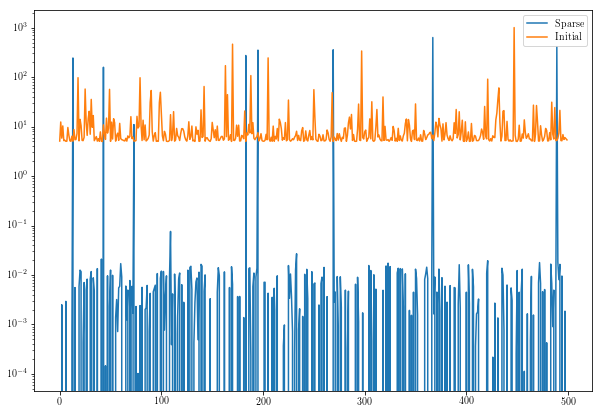

In [56]:
plt.figure(figsize=(10,7))
plt.plot(w.value, label="Sparse")
plt.plot(c, label="Initial")
plt.yscale("log")
plt.legend()

# Sparse covariance estimation for Gaussian variables

## Introduction

Suppose $y \in \mathbf{\mbox{R}}^n$ is a Gaussian random variable with zero mean and
covariance matrix $R = \mathbf{\mbox{E}}[yy^T]$, with sparse inverse $S = R^{-1}$
($S_{ij} = 0$ means that $y_i$ and $y_j$ are conditionally independent).
We want to estimate the covariance matrix $R$ based on $N$ independent
samples $y_1,\dots,y_N$ drawn from the distribution, and using prior knowledge
that $S$ is sparse

A good heuristic for estimating $R$ is to solve the problem
  $$\begin{array}{ll}
    \mbox{maximize}   & \log \det(S) - \mbox{tr}(SY) \\
    \mbox{subject to} & \sum_{i=1}^n \sum_{j=1}^n |S_{ij}| \le \alpha \\
                      & S \succeq 0,
    \end{array}$$
where $Y$ is the sample covariance of $y_1,\dots,y_N$, and $\alpha$ is a sparsity
parameter to be chosen or tuned.

**Remark**: more detailed description of the objective function is given [here](http://people.eecs.berkeley.edu/~jordan/courses/260-spring10/other-readings/chapter13.pdf), in particular eq. (13.50)

## Generate problem data

In [78]:
import cvxpy as cp
import numpy as np
import scipy as scipy

# Dimension of matrix.
n = 10

# Number of samples, y_i
N = 1000

# Create sparse, symmetric PSD matrix S
A = np.random.randn(n, n)  # Unit normal gaussian distribution.
A[scipy.sparse.rand(n, n, 0.85).todense().nonzero()] = 0  # Sparsen the matrix.
Strue = A.dot(A.T) + 0.05 * np.eye(n)  # Force strict pos. def.

# Create the covariance matrix associated with S.
R = np.linalg.inv(Strue)

# Create samples y_i from the distribution with covariance R. 
y_sample = scipy.linalg.sqrtm(R).dot(np.random.randn(n, N))

# Calculate the sample covariance matrix.
Y = np.cov(y_sample)

In [79]:
alpha = n
S = cp.Variable(shape=(n,n), PSD=True)
obj = cp.Maximize(cp.log_det(S) - cp.trace(S * Y))

# Set constraint.
constraints = [cp.sum(cp.abs(S)) <= alpha]

# Form and solve optimization problem
prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.SCS, verbose=True)

# If the covariance matrix R is desired, here is how it to create it.
R_hat = np.linalg.inv(S.value)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1415, CG tol ~ 1/iter^(2.00)
eps = 1.00e-04, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 485, constraints m = 906
Cones:	primal zero / dual free vars: 355
	linear vars: 201
	sd vars: 320, sd blks: 3
	exp vars: 30, dual exp vars: 0
Setup time: 8.79e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf       nan      -inf       inf       inf  2.70e-03 
   100| 3.48e-03  3.42e-03  9.82e-03  2.10e+01  2.14e+01  1.71e-14  3.18e-02 
   200| 1.43e-03  1.09e-03  3.07e-03  2.23e+01

In [80]:
# Threshold S element values to enforce exact zeros:
S = S.value
S[abs(S) <= 1e-4] = 0

<Figure size 432x288 with 0 Axes>

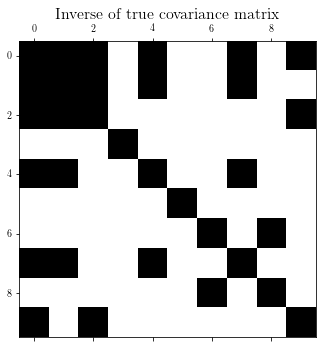

Text(0.5, 1.05, 'Estimated inv. cov matrix, $\\alpha$=10')

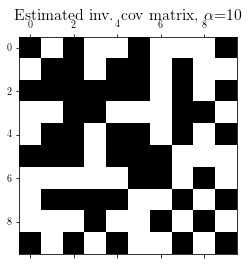

In [81]:
import matplotlib.pyplot as plt

# Show plot inline in ipython.
%matplotlib inline

# Plot properties.
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Create figure.
plt.figure()
plt.figure(figsize=(12, 12))

# Plot sparsity pattern for the true covariance matrix.
plt.subplot(2, 2, 1)
plt.spy(Strue)
plt.title('Inverse of true covariance matrix', fontsize=16)
plt.show()

# Plot sparsity pattern for each result, corresponding to a specific alpha.
plt.spy(S)
plt.title('Estimated inv. cov matrix, $\\alpha$={}'.format(alpha), fontsize=16)

In [84]:
x = cp.Variable(2)
# problem = cp.Problem(cp.Minimize(cp.norm(x)), [x[0] >= 0, x[1] * x[0] >= 0])
problem = cp.Problem(cp.Minimize(cp.norm(x)), [cp.bmat([[x[0], 0], [0, x[1]]]) >> 0])
problem.solve(solver=cp.SCS)

-1.0582655424918567e-09

In [85]:
x.value

array([0., 0.])